In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import random

In [2]:
random.seed(42)

## Preprocessing

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset
dataset_path = r"D:\MS-AI\2ndSem\AIPM\Lab\AIPM---Skin-Disease-Detection\dataset"

# Define image size
image_size = (96, 96)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,  # Random rotation between -30 and 30 degrees
    horizontal_flip=True,  # Random horizontal flip
)

# This will store image data and labels
metadata = []

def preprocess_images_from_folder(folder_path, class_name):
    """
    Process all images from a folder and store the image data and labels into the metadata list.
    :param folder_path: The path to the folder containing images
    :param class_name: The class name (folder name) of the images
    """
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(root, file)
                
                # Read the image using OpenCV
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB

                # Resize the image to the target size
                img_resized = cv2.resize(img, image_size)

                # Normalize the image
                img_resized_norm = img_resized / 255.0

                # Add the image data (as a 3D array) and label to metadata
                metadata.append({
                    'image_data': img_resized_norm,
                    'class': class_name
                })

                # Apply augmentation if necessary (not saving augmented images for CSV)
                img_resized_norm = np.expand_dims(img_resized_norm, axis=0)  # Add batch dimension
                """augmented_gen = datagen.flow(img_resized_norm, batch_size=1)

                for _ in range(1):  # Generate augmented images
                    augmented_img = next(augmented_gen)[0]

                    # Add augmented image data (as a 3D array) and label to metadata
                    metadata.append({
                        'image_data': augmented_img,
                        'class': class_name
                    })"""

def process_dataset(dataset_path):
    """
    Loop through the 'train' and 'test' directories and preprocess all images
    :param dataset_path: The root path of the dataset
    """
    # Process the 'train' folder
    train_dir = os.path.join(dataset_path, 'train')
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        preprocess_images_from_folder(class_path, class_name)

    # Process the 'test' folder
    test_dir = os.path.join(dataset_path, 'test')
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        preprocess_images_from_folder(class_path, class_name)

# Collect metadata and save to CSV
def save_metadata_to_csv(metadata):
    metadata_df = pd.DataFrame(metadata)
    metadata_df.to_csv('image_metadata.csv', index=False)
    print("Metadata saved to 'image_metadata.csv'")

# Save image data as a numpy file (.npz) containing arrays
def save_metadata_to_npz(metadata, filename='image_data.npz'):
    # Convert metadata to numpy arrays
    images = np.array([entry['image_data'] for entry in metadata])
    labels = np.array([entry['class'] for entry in metadata])

    # Save both images and labels in a compressed .npz file
    np.savez_compressed(filename, images=images, labels=labels)
    print(f"Metadata saved to {filename}")


# Run the preprocessing
process_dataset(dataset_path)

# Usage
save_metadata_to_npz(metadata)


Metadata saved to image_data.npz


In [4]:
# Loading data from the .npz file
data = np.load('image_data.npz')
X = data['images']  # This will have shape (num_samples, 64, 64, 3)
y = data['labels']

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert text labels to numeric labels
y = label_encoder.fit_transform(y)
y_categorical = to_categorical(y, num_classes=23)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
X_train = np.array(X_train, dtype=np.float32)


## Model creation

In [6]:
# Initialize the CNN model
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(23, activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


C:\Users\Administrator\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 23)                  │           2,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,987,415 (15.21 MB)

 Trainable params: 3,987,415 (15.21 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Split data manually (instead of using validation_split)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model with explicit validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


# Save the trained model
model.save('skin_disease_model.h5')


Epoch 1/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - accuracy: 0.1057 - loss: 2.9954 - val_accuracy: 0.1562 - val_loss: 2.8249
Epoch 2/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.1461 - loss: 2.8333 - val_accuracy: 0.1895 - val_loss: 2.7432
Epoch 3/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.1824 - loss: 2.7412 - val_accuracy: 0.2109 - val_loss: 2.6940
Epoch 4/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.2133 - loss: 2.6418 - val_accuracy: 0.2121 - val_loss: 2.6572
Epoch 5/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.2407 - loss: 2.5090 - val_accuracy: 0.2275 - val_loss: 2.6306
Epoch 6/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.2752 - loss: 2.3683 - val_accuracy: 0.2399 - val_loss: 2.6263
Epoch 7/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.3217 - loss: 2.2214 - val_accuracy: 0.2428 - val_loss: 2.6295
Epoch 8/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.3839 - loss: 2.0203 - 

In [8]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2606 - loss: 2.9099
Test Accuracy: 26.48%


In [7]:
# Initialize the CNN model
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(23, activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 128)        

In [23]:
# Split data manually (instead of using validation_split)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model with explicit validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


# Save the trained model
model.save('skin_disease_model.h5')


Epoch 1/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.0842 - loss: 3.0218 - val_accuracy: 0.0985 - val_loss: 2.9340
Epoch 2/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.1060 - loss: 2.9567 - val_accuracy: 0.1148 - val_loss: 2.9110
Epoch 3/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.1235 - loss: 2.9143 - val_accuracy: 0.1308 - val_loss: 2.8849
Epoch 4/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.1267 - loss: 2.8916 - val_accuracy: 0.1390 - val_loss: 2.8654
Epoch 5/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.1458 - loss: 2.8517 - val_accuracy: 0.1450 - val_loss: 2.8341
Epoch 6/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.1473 - loss: 2.8140 - val_accuracy: 0.1496 - val_loss: 2.8170
Epoch 7/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.1514 - loss: 2.7915 - val_accuracy: 0.1576 - val_loss: 2.7918
Epoch 8/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.1740 - loss: 2.7475 - 

In [24]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2078 - loss: 2.6638
Test Accuracy: 20.30%


## Grid Search

In [6]:
from sklearn.model_selection import GridSearchCV
def create_model(neuron=32, optimizator='adam', dropout_rate=0.0):
    model = Sequential([
        Dense(neuron, input_dim=X_train.shape[1], activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(len(np.unique(y)), activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizator, metrics=['accuracy'])
    return model


In [7]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D

# Defining the models to be used
random_state = 42

models = {
    "DecisionTree": DecisionTreeRegressor(random_state=random_state),
    "RandomForest": RandomForestRegressor(random_state=random_state)
}

param_grids = {
    "DecisionTree": {
        "max_depth": [3, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "RandomForest": {
        "n_estimators": [50, 100],
        "max_depth": [5, 10]
    }
}

best_models = {}
X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Grid Search for each model
for name, model in models.items():
    print(f"Optimizing {name}...")
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        scoring="neg_mean_absolute_error",
        cv=3,  # Reduce the number of folds for faster execution
        n_jobs=-1
    )
    grid_search.fit(X_train_2d[:1000], y_train[:1000])
    
    best_models[name] = grid_search.best_estimator_
    print(f"Best hyperparameters for {name}: {grid_search.best_params_}\n")


Optimizing DecisionTree...
Best hyperparameters for DecisionTree: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}

Optimizing RandomForest...
Best hyperparameters for RandomForest: {'max_depth': 10, 'n_estimators': 50}



In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)


In [10]:
# Best hyperparameters for DecisionTree from GridSearchCV
best_dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5)

# Train DecisionTreeRegressor with the best parameters
best_dt.fit(X_train_2d, y_train)
y_pred_dt = best_dt.predict(X_test_2d)

# Evaluate models
print("DecisionTreeRegressor Evaluation:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_dt)}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_dt)}")
print(f"R^2 Score: {r2_score(y_test, y_pred_dt)}\n")


DecisionTreeRegressor Evaluation:
Mean Absolute Error (MAE): 0.07803058764153586
Mean Squared Error (MSE): 0.04130317913809185
R^2 Score: -0.014608306739762824



In [10]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load the data
data = np.load('image_data.npz')
X = data['images']
y = data['labels']

# Flatten image data for DecisionTree (samples, 64*64*3)
X = X.reshape(X.shape[0], -1)

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Smaller, faster parameter grid
param_grid = {
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'criterion': ['gini']
}

# GridSearchCV setup
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='accuracy', n_jobs=1, verbose=1)

# Fit model
grid_search.fit(X_train, y_train)

# Results
print("Best Parameters:", grid_search.best_params_)
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")


Fitting 3 folds for each of 4 candidates, totalling 12 fits


KeyboardInterrupt: 

Test Accuracy: 16.14%

Confusion Matrix:
 [[112  38   1   1   0  28   1   0   0  22   3   2   2   0 128   1  56   4
   55   0   0   0  42]
 [ 36  79   1   2   5  31   1   0   0   6   4   4  10   3 168   0 139   9
   50   0   0   0  44]
 [ 18   9   9   2   0  45   0   1   1  15   0   0   6   2  73   0  16   4
   22   0   0   0   8]
 [ 18  14   0   0   0  23   0   2   0  18   1   0   0   0  68   0  31   2
   30   0   0   0  21]
 [ 10  11   1   0   2  20   2   0   1   2   0   1   0   1  50   0  12   1
   22   0   0   0  14]
 [ 58  27   9   1   0 166   1   1   0  24   3   0  12   2 178   2  37   5
   60   0   0   0  30]
 [ 11   6   2   0   0  28   1   2   0  22   7   1   7   0  54   0  13   3
   25   0   0   0  14]
 [  9   8   0   0   1   7   1   2   0   7   3   0   5   0  35   0  13   1
   21   0   1   0   1]
 [ 18  14   1   0   0  10   0   0   0   3   0   3   0   1  68   0  24   2
   21   0   0   0  25]
 [ 20  18   4   0   0  36   2   0   0  19   5   1   5   0  70   0  25   3
   41   0  

C:\Users\Administrator\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


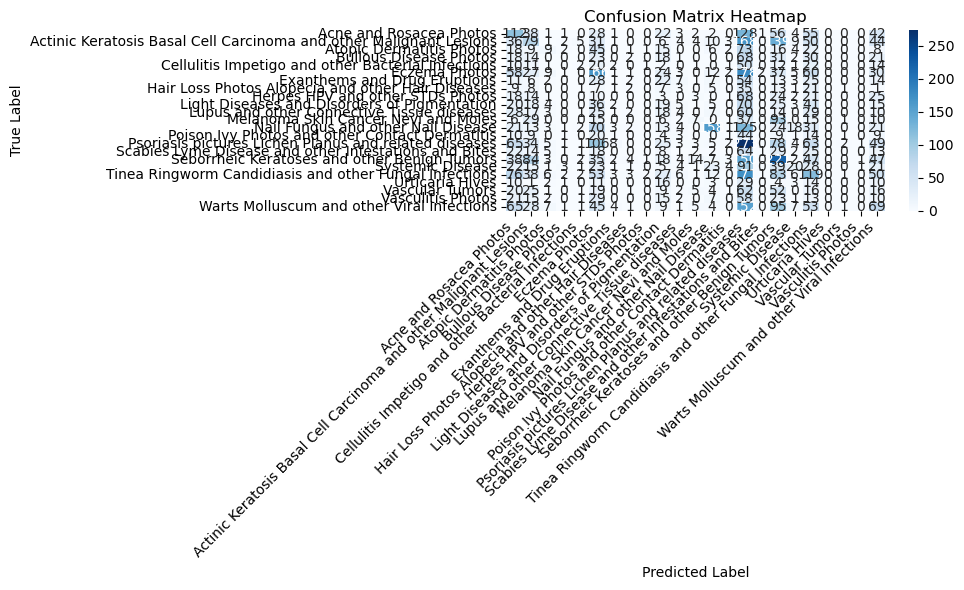

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train model with best parameters
dt_best = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
dt_best.fit(X_train, y_train)

# Predict
y_pred = dt_best.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

X_flat shape: (39118, 12288)
X_pca shape after PCA: (39118, 50)
Accuracy: 0.1649

Classification Report:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.16      0.20      0.18       496
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.17      0.13      0.14       592
                                          Atopic Dermatitis Photos       0.14      0.02      0.04       231
                                            Bullous Disease Photos       0.07      0.01      0.02       228
                Cellulitis Impetigo and other Bacterial Infections       0.06      0.01      0.01       150
                                                     Eczema Photos       0.15      0.31      0.20       616
                                      Exanthems and Drug Eruptions       0.06      0.01      0.01       196
                 Hair Loss Pho

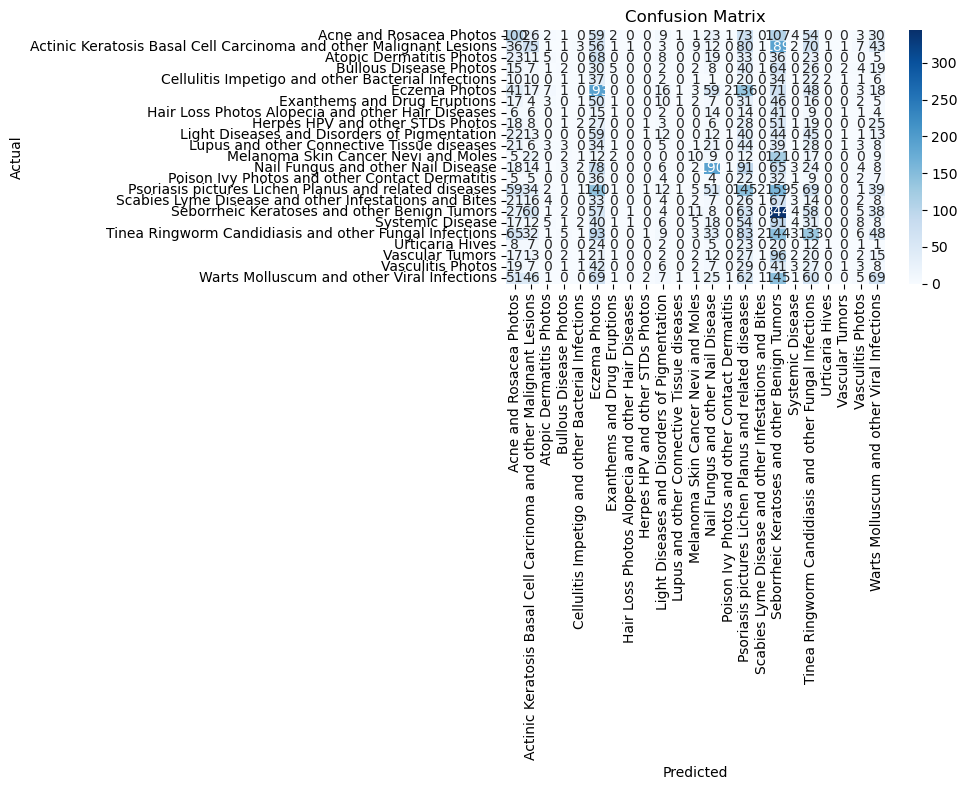

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Encode labels if not done already
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Use your actual target variable here

# Flatten image data if not already done (X must be 2D: samples x features)
X_flat = X.reshape(X.shape[0], -1)  # Shape becomes (samples, features)

# Optional: Print shape
print("X_flat shape:", X_flat.shape)

# PCA to reduce features
pca = PCA(n_components=50, random_state=42)  # You can try 30 or 100 too
X_pca = pca.fit_transform(X_flat)

print("X_pca shape after PCA:", X_pca.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

# Decision Tree with best parameters from regression
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)

# Train model
dt.fit(X_train, y_train)

# Predict
y_pred = dt.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------- Load and Preprocess Data ------------------------
# Load data from the .npz file
data = np.load('image_data.npz')
X = data['images']
y = data['labels']

# Normalize the images
X = X.astype('float32') / 255.0

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=23)

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# ---------------------- Build Transfer Learning Model ------------------------
input_shape = (100, 100, 3)
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(23, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ---------------------- Train the Model ------------------------
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# ---------------------- Evaluate on Test Set ------------------------
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

# ---------------------- Classification Report & Confusion Matrix ------------------------
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ---------------------- Save the Model ------------------------
model.save('skin_disease_model_mobilenetv2.h5')


ModuleNotFoundError: No module named 'matplotlib'

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 52s 123ms/step - accuracy: 0.0749 - loss: 3.4285 - val_accuracy: 0.1131 - val_loss: 2.9867
Epoch 2/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 55s 140ms/step - accuracy: 0.0933 - loss: 3.0496 - val_accuracy: 0.0891 - val_loss: 2.9764
Epoch 3/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 54s 137ms/step - accuracy: 0.0982 - loss: 3.0187 - val_accuracy: 0.1022 - val_loss: 2.9780
Epoch 4/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 52s 132ms/step - accuracy: 0.1003 - loss: 3.0071 - val_accuracy: 0.1080 - val_loss: 2.9602
Epoch 5/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.1040 - loss: 2.9905 - val_accuracy: 0.1045 - val_loss: 2.9624
Epoch 6/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 52s 131ms/step - accuracy: 0.1086 - loss: 2.9860 - val_accuracy: 0.1077 - val_loss: 2.9525
Epoch 7/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 50s 127ms/step - accuracy: 0.0988 - loss: 2.9819 - val_accuracy: 0.1058 - val_loss: 2.9457
Epoch 8/10
392/392 ━━━━━━━━━━━━━━━

C:\Users\Administrator\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


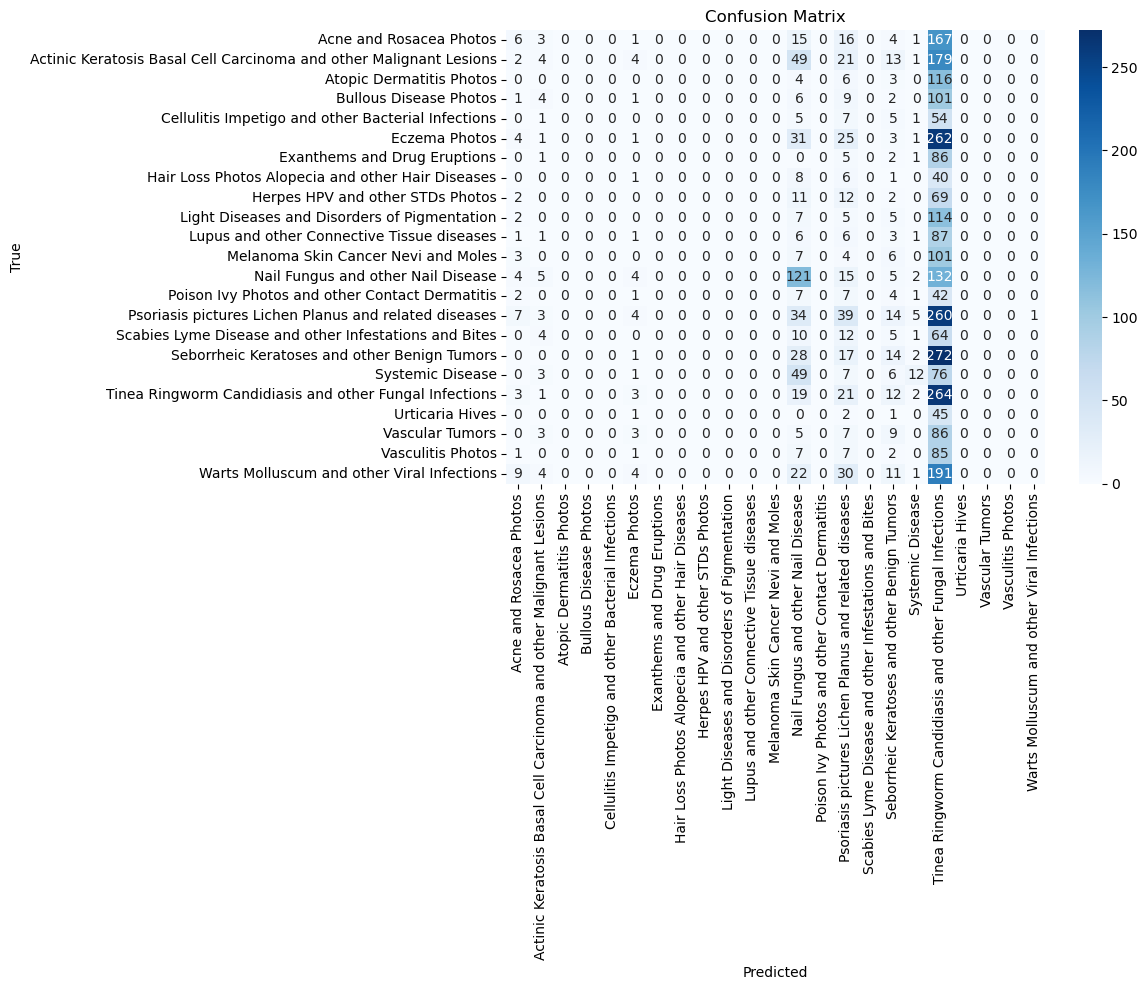

In [9]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc

# Load data
data = np.load('image_data.npz', allow_pickle=True)
X = data['images'].astype(np.int32)
y = data['labels']
del data  # free memory


# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_cat = to_categorical(y, num_classes=23)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Free unused memory
gc.collect()

# Build Model with MobileNetV2
def build_model(input_shape=(96, 96, 3), num_classes=23):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze base
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Train
history = model.fit(X_train, y_train, batch_size=32,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    verbose=1)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# Predict and Confusion Matrix
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Save the model
model.save('mobilenetv2_skin_model.h5')
